<a href="https://colab.research.google.com/github/Abuton/AnalyticsVidhya-Job-A-Thon/blob/main/Job_A_thon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [111]:
# reading the data as a pandas dataframe
train = pd.read_csv('train_Df64byy.csv')
test = pd.read_csv('test_YCcRUnU.csv')

train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [112]:
# merge train with test for ease of analysis and feature engineering
df = pd.concat([train, test], ignore_index=True)

df.shape

(72687, 14)

In [113]:
# fill missing values with arbitrary numbers
df['Health Indicator'] = df['Health Indicator'].fillna(-999)
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].fillna(-999)
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].fillna(-999)

df.isna().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator               0
Holding_Policy_Duration        0
Holding_Policy_Type            0
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                   21805
dtype: int64

## Exploratory Analysis (Bi variate)
considering the Target `Response`

In [6]:
# how does Accomodation Type Realte with the target
target = 'Response'
pd.crosstab(df[target], df['Accomodation_Type'], margins=True)

Accomodation_Type,Owned,Rented,All
Response,,,
0.0,21188,17485,38673
1.0,6763,5446,12209
All,27951,22931,50882


In [12]:
pd.crosstab(df[target], df['Reco_Insurance_Type'], margins=True, normalize=True)

Reco_Insurance_Type,Individual,Joint,All
Response,,,
0.0,0.607209,0.152844,0.760053
1.0,0.189458,0.050489,0.239947
All,0.796667,0.203333,1.000000


In [14]:
pd.crosstab(df[target], df['Health Indicator'], margins=True, normalize=True)

Health Indicator,X1,X2,X3,X4,X5,X6,X7,X8,X9,All
Response,,,,,,,,,,
0.0,0.250925,0.200071,0.131739,0.110918,0.033656,0.024827,0.003419,0.001531,0.001250,0.758337
1.0,0.081039,0.063561,0.040800,0.035620,0.010411,0.007833,0.001582,0.000459,0.000357,0.241663
All,0.331964,0.263632,0.172540,0.146539,0.044066,0.032661,0.005001,0.001990,0.001608,1.000000


In [15]:
pd.crosstab(df[target], df['Holding_Policy_Duration'], margins=True, normalize=True)


Holding_Policy_Duration,1.0,10.0,11.0,12.0,13.0,14+,14.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
Response,,,,,,,,,,,,,,,,
0.0,0.114329,0.019294,0.013352,0.012504,0.012177,0.106036,0.011459,0.106069,0.089909,0.068689,0.058731,0.047305,0.039894,0.031928,0.027717,0.759394
1.0,0.032549,0.007248,0.004473,0.004244,0.004505,0.035487,0.003754,0.033006,0.027162,0.021775,0.018380,0.014528,0.013810,0.011035,0.008651,0.240606
All,0.146877,0.026542,0.017825,0.016748,0.016682,0.141523,0.015213,0.139075,0.117071,0.090464,0.077111,0.061833,0.053704,0.042963,0.036368,1.000000


In [16]:
pd.crosstab(df[target], df['Holding_Policy_Type'], margins=True, normalize=True)



Holding_Policy_Type,1.0,2.0,3.0,4.0,All
Response,,,,,
0.0,0.203911,0.124547,0.328491,0.102445,0.759394
1.0,0.062910,0.038850,0.105024,0.033822,0.240606
All,0.266821,0.163397,0.433515,0.136267,1.000000


In [114]:
# these columns were dropped after initial analysis and were not found to be too useful in terms of explaining customers subscribing for a health insurance
cols_2_drop = ['ID', 'Upper_Age', 'Lower_Age', 'Reco_Insurance_Type']

# specifying the category columns 
cat_columns = ['City_Code', 'Region_Code', 'Health Indicator', 'Accomodation_Type', 'Reco_Policy_Cat', 'Is_Spouse']

map_reco = {'Individual': 1, 'Joint': 0}
map_accomodation = {'Rented': 0, 'Owned': 1}

def transform_Holding_Policy_Duration(Holding_Policy_Duration):
  df[Holding_Policy_Duration] = df[Holding_Policy_Duration].replace('14+', 15, regex=True).astype(float)
  return df[Holding_Policy_Duration]

# function to calculate feature engineering by aggregating integer columns
def get_agg_by_cols(data, col, agg_list, agg_cols):
    """
    data : dataframe to calculate FE on
    col : list of columns to aggregate by (the object datatype)
    agg_list : a list of statistical measure e.g mean, median
    agg_cols : a list of numerical datatype columns
    """
    for cols in col:
        for i in agg_list:
            for j in agg_cols:
                data[cols+'_'+j+'_'+i] = data.groupby([cols])[j].transform(i)
    return data


In [115]:
columns = ['Health Indicator', 'Reco_Policy_Cat']
agg_list = ['mean', 'std']
agg_cols = ['Reco_Policy_Premium', 'Average_Age']

In [116]:
# more feature engineering
df['Average_Age'] = (df['Upper_Age'] + df['Lower_Age']) / 2
df['Reco_Policy_Premium_square'] = df['Reco_Policy_Premium'] ** 2

In [117]:
# transform the data
df = get_agg_by_cols(data=df, col=columns, agg_list=agg_list, agg_cols=agg_cols)
df['Reco_Insurance_Type'] = df['Reco_Insurance_Type'].map(map_reco)
df['Accomodation_Type'] = df['Accomodation_Type'].map(map_accomodation)

df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].replace('14+', 15, regex=True).astype(float)

df = df.drop(columns=cols_2_drop, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72687 entries, 0 to 72686
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   City_Code                                  72687 non-null  object 
 1   Region_Code                                72687 non-null  int64  
 2   Accomodation_Type                          72687 non-null  int64  
 3   Is_Spouse                                  72687 non-null  object 
 4   Health Indicator                           72687 non-null  object 
 5   Holding_Policy_Duration                    72687 non-null  float64
 6   Holding_Policy_Type                        72687 non-null  float64
 7   Reco_Policy_Cat                            72687 non-null  int64  
 8   Reco_Policy_Premium                        72687 non-null  float64
 9   Response                                   50882 non-null  float64
 10  Average_Age           

In [118]:
# split back into train set and test sets
import warnings 
warnings.filterwarnings('ignore')

train_df = df[:len(train)]
test_df = df[len(train):]

test_df.drop(target, axis=1, inplace=True)


In [119]:
# select the features and targets
X = train_df.drop(target, axis=1)
y = train_df[target].astype(int)

assert len(X.columns.values) == len(test_df.columns.values)

In [ ]:
!pip install catboost

In [121]:
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
kfold, scores, y_pred_totcb = StratifiedKFold(n_splits=5, shuffle=True, random_state=221), list(), []
for train, test in kfold.split(X, y):
    x_train, x_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    model = CatBoostClassifier(random_state=27,  n_estimators=3000, cat_features = cat_columns,
                               max_depth=7, verbose=500, learning_rate=0.102, eval_metric='AUC')
    model.fit(x_train, y_train, eval_set=(x_test, y_test))
    preds = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test, preds)
    scores.append(score)
    print(score)
    test_pred = model.predict_proba(test_df)[:,1]
    y_pred_totcb.append(test_pred)
print("Average: ", sum(scores)/len(scores))

0:	test: 0.5863431	best: 0.5863431 (0)	total: 93.2ms	remaining: 4m 39s
500:	test: 0.8013488	best: 0.8036775 (219)	total: 39.1s	remaining: 3m 14s
1000:	test: 0.7995125	best: 0.8036775 (219)	total: 1m 19s	remaining: 2m 39s
1500:	test: 0.7964525	best: 0.8036775 (219)	total: 2m 1s	remaining: 2m 1s
2000:	test: 0.7934589	best: 0.8036775 (219)	total: 2m 43s	remaining: 1m 21s
2500:	test: 0.7902194	best: 0.8036775 (219)	total: 3m 25s	remaining: 41.1s
2999:	test: 0.7879800	best: 0.8036775 (219)	total: 4m 9s	remaining: 0us

bestTest = 0.8036774566
bestIteration = 219

Shrink model to first 220 iterations.
0.8036774566186331
0:	test: 0.6123715	best: 0.6123715 (0)	total: 86.1ms	remaining: 4m 18s
500:	test: 0.8009528	best: 0.8023748 (255)	total: 39.7s	remaining: 3m 17s
1000:	test: 0.7980375	best: 0.8023748 (255)	total: 1m 21s	remaining: 2m 42s
1500:	test: 0.7945047	best: 0.8023748 (255)	total: 2m 3s	remaining: 2m 3s
2000:	test: 0.7926261	best: 0.8023748 (255)	total: 2m 45s	remaining: 1m 22s
2500:	te

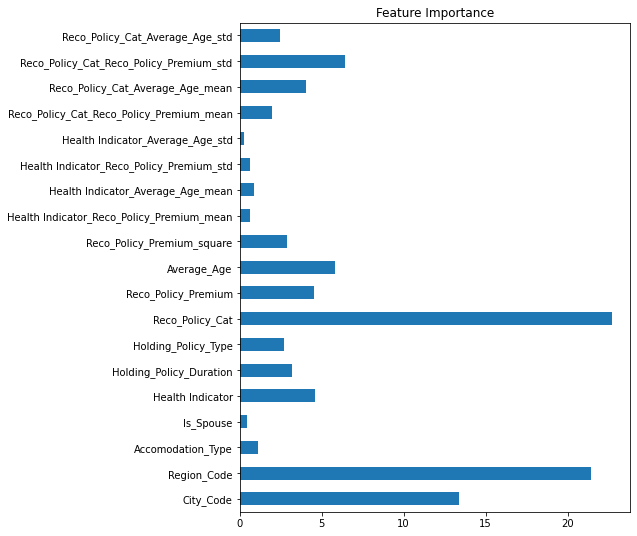

In [122]:
fea_imp = pd.Series(model.feature_importances_, index=X.columns)
fea_imp.plot.barh(figsize=(7, 9), title='Feature Importance')

In [35]:
np.mean(y_pred_totcb, 0)

array([0.07078154, 0.15242677, 0.63055845, ..., 0.01987155, 0.32827891,
       0.11447735])

In [123]:
sub = pd.read_csv('sample_submission_QrCyCoT.csv')

sub[target] = np.mean(y_pred_totcb, 0)

In [124]:
sub.to_csv('just_cats8.csv', index=False)

In [125]:
# stacked model results using weighted average
a = pd.read_csv('just_cats6.csv')
b = pd.read_csv('just_cats8.csv')

c = (a['Response']*0.7 + b['Response']*0.3) / 2

In [126]:
sub[target] = c
sub.to_csv('just_cats_stacked_9.csv', index=False)